# Data characterization

L. F. Pereira (lfpereira@fe.up.pt)  
July 7, 2020

Note: There's a bigger dataset available, but the analyses are performed with the same data provided to WB2332 students.

In order to use shared code, the notebook work directory iss set to main.

In [1]:
import os

os.chdir('..')

In [2]:
os.getcwd()

'D:\\General\\GitHub\\misc\\machine_learning\\supercompressible'

In [3]:
# standard library
import pickle
import itertools

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from scipy import stats

# local library
from utils import perform_iter_outlier_cleaning
from utils import perform_outlier_cleaning
from f3das.post_processing.common import get_results
from f3das.post_processing.supercompressible import get_results_lin_buckle
from f3das.post_processing.supercompressible import read_and_clean_results_riks

In [4]:
# %matplotlib qt

In order to plot curves, define the path for the place when is raw-stored.

In [5]:
data_dir = 'D:\\General\\GitHub\\F3DAS\\F3DAS (fork)\\example_supercompressible_3d_circular\\analyses'

Let's open the file and store all the information in the Python environment.

In [6]:
# TODO: update original dataset and use only required points

filename = '3d/DoE_results_3d_1k.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
    
print(data)

{'doe_variables': OrderedDict([('ratio_d', [0.004, 0.073]), ('ratio_pitch', [0.25, 1.5]), ('ratio_top_diameter', [0.0, 0.8])]), 'points':       ratio_d  ratio_pitch  ratio_top_diameter               coilable  \
0    0.004000     0.250000            0.000000               coilable   
1    0.038500     0.875000            0.400000           not coilable   
2    0.055750     0.562500            0.200000  coilable (but yields)   
3    0.021250     1.187500            0.600000           not coilable   
4    0.029875     0.718750            0.500000               coilable   
..        ...          ...                 ...                    ...   
995  0.023474     0.917725            0.564844           not coilable   
996  0.032099     0.448975            0.664844               coilable   
997  0.066599     1.073975            0.264844  coilable (but yields)   
998  0.049349     0.761475            0.464844  coilable (but yields)   
999  0.014849     1.386475            0.064844           no

In [7]:
# define number of points to start with
N = 1000
df = data['points'].loc[:(N-1)]
print(df)

      ratio_d  ratio_pitch  ratio_top_diameter               coilable  \
0    0.004000     0.250000            0.000000               coilable   
1    0.038500     0.875000            0.400000           not coilable   
2    0.055750     0.562500            0.200000  coilable (but yields)   
3    0.021250     1.187500            0.600000           not coilable   
4    0.029875     0.718750            0.500000               coilable   
..        ...          ...                 ...                    ...   
995  0.023474     0.917725            0.564844           not coilable   
996  0.032099     0.448975            0.664844               coilable   
997  0.066599     1.073975            0.264844  coilable (but yields)   
998  0.049349     0.761475            0.464844  coilable (but yields)   
999  0.014849     1.386475            0.064844           not coilable   

     sigma_crit     energy  
0      0.000494   0.000280  
1           NaN        NaN  
2     23.052002  14.285320  
3      

To make sure all the data is properly labeled in the plots, let's create **meaningful labels**. To make it easy to use, each variable is represented by a tuple, where the first component is the name of the variable in the dataset and the second component corresponds to its label and the third to its bounds.

In [8]:
# inputs
input_vars = [('ratio_d', '$\\frac{d}{D_1}$'), ('ratio_pitch', '$\\frac{P}{D}$'),
              ('ratio_top_diameter', '$\\frac{D_1 - D_2}{D_1}$')]
for i, input_var in enumerate(input_vars):
    input_vars[i] = input_var + (data['doe_variables'][input_var[0]],)

print(input_vars)

# outputs
output_vars = [('coilable', 'coilable'), ('sigma_crit', '$\\sigma_{crit}$'),
               ('energy', '$E_{abs}$')]

[('ratio_d', '$\\frac{d}{D_1}$', [0.004, 0.073]), ('ratio_pitch', '$\\frac{P}{D}$', [0.25, 1.5]), ('ratio_top_diameter', '$\\frac{D_1 - D_2}{D_1}$', [0.0, 0.8])]


## Input variables

Let's forget the outputs for a while and take a look to the **input** variables.

We can clearly see that all the inputs are **float** and drawn **uniformly** in a well defined **rectangular** range.

In [9]:
for input_var in input_vars:
    print(df[input_var[0]].describe())
    print('\n')

count    1000.000000
mean        0.038481
std         0.019928
min         0.004000
25%         0.021233
50%         0.038466
75%         0.055699
max         0.072933
Name: ratio_d, dtype: float64


count    1000.000000
mean        0.874600
std         0.361010
min         0.250000
25%         0.562195
50%         0.874390
75%         1.186584
max         1.498779
Name: ratio_pitch, dtype: float64


count    1000.000000
mean        0.399644
std         0.231048
min         0.000000
25%         0.199805
50%         0.399609
75%         0.599414
max         0.799219
Name: ratio_top_diameter, dtype: float64




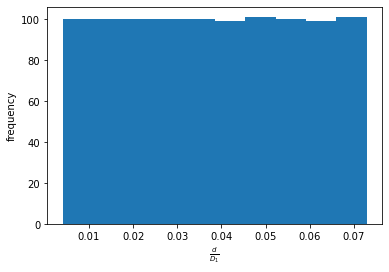

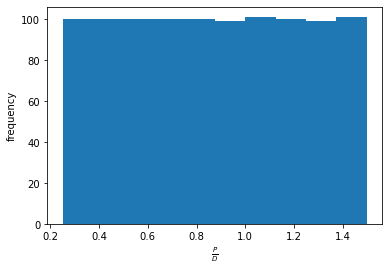

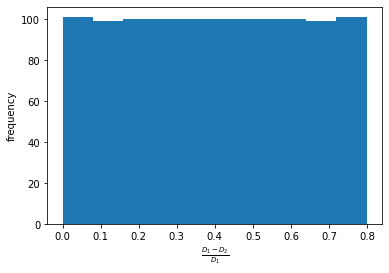

In [10]:
for input_var in input_vars:
    fig, ax = plt.subplots()
    ax.hist(df[input_var[0]])
    ax.set_xlabel(input_var[1])
    ax.set_ylabel('frequency')

Now, let's convert the input data to a more *amenable* representation.

In [11]:
# get number of inputs
n_inputs = len(df.columns) - 3

# get X data
X = df.iloc[:, range(n_inputs)].values.copy()

print('X:', X)
print('X shape:', np.shape(X))

X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06659863 1.07397461 0.26484375]
 [0.04934863 0.76147461 0.46484375]
 [0.01484863 1.38647461 0.06484375]]
X shape: (1000, 3)


Using **scatter** plots, we can plot all the variables in pairs. Although not very useful, these plots reflect the way the dataset was generated (the space is **densely** and **uniformly** (not in a grid sense) filled).

In [12]:
# get all possible combinations of 2 inputs
combinations = list(itertools.combinations(range(n_inputs), 2))

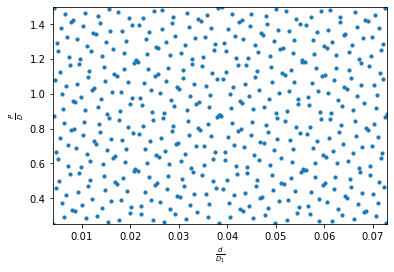

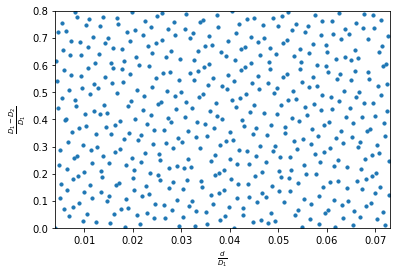

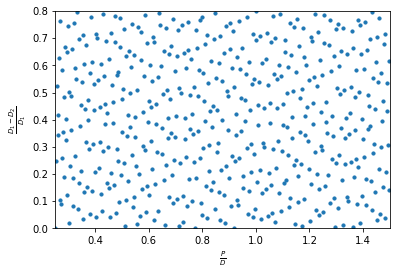

In [13]:
# select the points to visualize
n = 500

# plot all combinations of features
for comb in combinations:
    i, j = comb
    xx = X[:n, i]
    yy = X[:n, j]

    plt.figure()
    plt.scatter(xx, yy, s=10)
    plt.xlabel(input_vars[i][1])
    plt.ylabel(input_vars[j][1])
    plt.xlim(input_vars[i][2][0], input_vars[i][2][1])
    plt.ylim(input_vars[j][2][0], input_vars[j][2][1])

The following are more compacted representations of the same information.

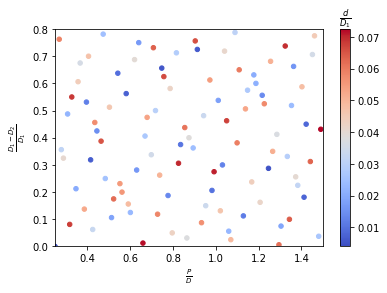

Text(0.5, 0, '$\\frac{d}{D_1}$')

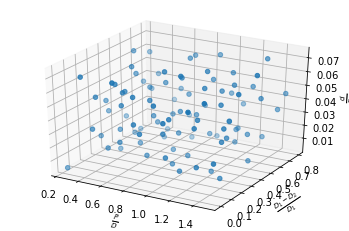

In [14]:
n = 100
i, j, k = 1, 2, 0
xx = X[:n, i]
yy = X[:n, j]
zz = X[:n, k]

# 2d representation
plt.figure()
plt.scatter(xx, yy, s=20, c=zz, cmap=plt.cm.coolwarm)
plt.xlabel(input_vars[i][1])
plt.ylabel(input_vars[j][1])
plt.xlim(input_vars[i][2][0], input_vars[i][2][1])
plt.ylim(input_vars[j][2][0], input_vars[j][2][1])
clb = plt.colorbar()
clb.ax.set_title(input_vars[k][1])
plt.show()

# 3d representation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz)
ax.set_xlabel(input_vars[i][1])
ax.set_ylabel(input_vars[j][1])
ax.set_zlabel(input_vars[k][1])

## Coilability

Let's now take a look to the classification output variable.

We can see that the classes are not completly balanced (there's more data that is *coilable (but yields)*), but that is not problematic (i.e. there's enough data of each category).

In [15]:
categs = ['not coilable', 'coilable', 'coilable (but yields)']
colors = ['r', 'g', 'b']
legend_elems = []
for color, categ in zip(colors, categs):
    legend_elems.append(Line2D([0], [0], marker='o', color='w',
                               markerfacecolor=color, label=categ))

y_df = pd.Categorical(df.coilable, categories=categs)

y_df.describe()

,counts,freqs
categories,,
not coilable,318,0.318
coilable,214,0.214
coilable (but yields),468,0.468


Next, we have to translate the ```str``` codification into an ```int``` codification. We could have used ```pandas.factorize```, but it is not flexible enough (i.e. is does not allow to choose the mapping).

In [16]:
# mapping str -> int
y = df.coilable.values.copy()
for i, categ in enumerate(categs):
    y[np.where(y==categ)]=i
    
# and a variable that stores colors
y_c = [colors[yy] for yy in y] 

The 2d plots feature against feature can give us a sense of the difficulty of the problem. We can clearly see trends in the data.

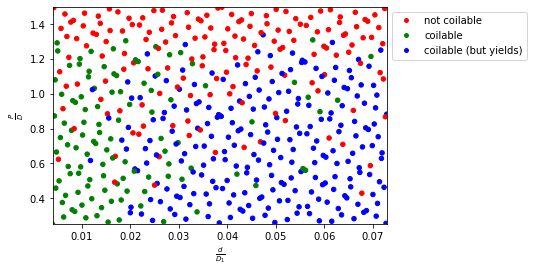

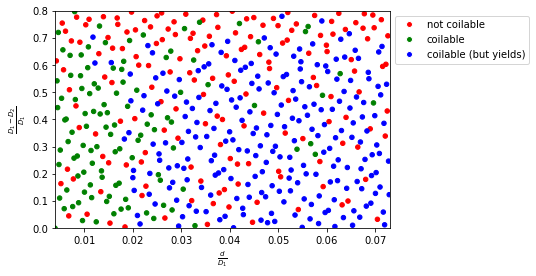

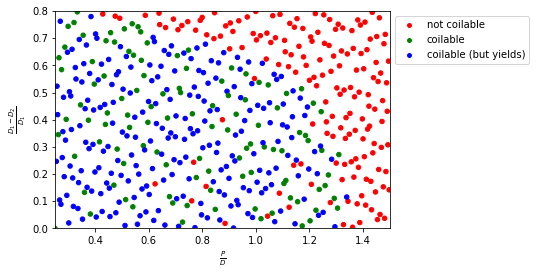

In [17]:
n = 500
s = 20

# 2d representation
for comb in combinations:
    i, j = comb
    fig, ax = plt.subplots()
    xx = X[:n, i]
    yy = X[:n, j]
    ax.scatter(xx, yy, s=s, c=y_c[:n])

    ax.set_xlabel(input_vars[i][1])
    ax.set_ylabel(input_vars[j][1])
    ax.set_xlim(input_vars[i][2][0], input_vars[i][2][1])
    ax.set_ylim(input_vars[j][2][0], input_vars[j][2][1])
    ax.legend(handles=legend_elems, bbox_to_anchor=(1, 1))

The 3d representation also shows that the data is clearly clusterized and supports the *easiness* of the problem.

Text(0.5, 0, '$\\frac{d}{D_1}$')

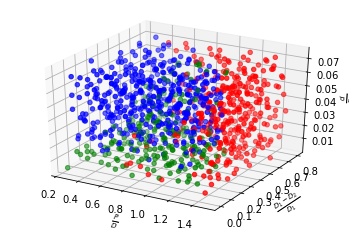

In [18]:
n = 1000
i, j, k = 1, 2, 0
xx = X[:n, i]
yy = X[:n, j]
zz = X[:n, k]

# 3d representation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=y_c[:n])
ax.set_xlabel(input_vars[i][1])
ax.set_ylabel(input_vars[j][1])
ax.set_zlabel(input_vars[k][1])

In [19]:
y_coil_full = y

## Energy absorbed

Let's now look to the energy absorbed.

In [20]:
var = output_vars[2]

We can noticed that there's several **missing values**. The existence of **outliers** is also clear (compare the 75% with the max value).

In [21]:
df[var[0]].describe()

count    524.000000
mean      10.212722
std       12.659462
min        0.000280
25%        0.624001
50%        4.586051
75%       16.157745
max       73.917332
Name: energy, dtype: float64

In [22]:
# missing indices
indices = pd.notnull(df.loc[:, var[0]]).values

# get y data
doe_numbers_dirty = np.arange(N)[indices]
y_dirty = df.loc[indices, var[0]].values.copy()

An histogram can give further insights.

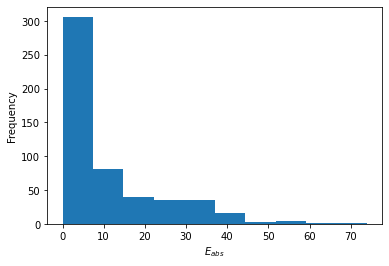

In [23]:
fig1, ax1 = plt.subplots()
ax1.hist(y_dirty);
ax1.set_xlabel(var[1])
ax1.set_ylabel('Frequency');

We must get rid of outliers (otherwise they can compromise the learning process). Several strategies that can be used. Here, I'll dismiss points that are $n$ standard deviations above the average. An iterative process is used to make sure all the outlier points are dismissed. An appropriate choice of $n$ could be performed looking to the outliers corresponding curves. This kind of strategy assumes data is gaussian, which is clearly not true.

**NOTE**: at the first look to the histogram, it looked like the points with the higher energy absorption were outliers. Nevertheless, when we look to the curves (see below), **NONE** of them are actual outliers. Neverthless, we know that there are outliers... therefore, better strategies (that are able to detect outliers in the "middle" of the data are required).

In [24]:
n_std = 3
indices, n_dismissed_pts = perform_iter_outlier_cleaning(y_dirty, n_std,)

y = y_dirty[indices]
doe_numbers = doe_numbers_dirty[indices]
print(n_dismissed_pts)

[7, 2, 0]


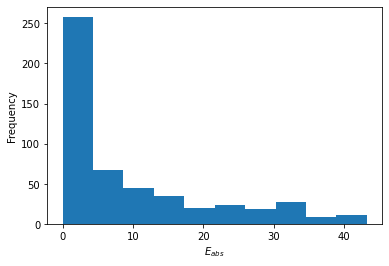

In [25]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel(var[1])
ax1.set_ylabel('Frequency');

In [26]:
pd.DataFrame({var[0]: y}).describe()

,energy
count,515.000000
mean,9.444165
std,11.288908
min,0.000280
25%,0.570941
50%,4.208751
75%,14.744981
max,43.241760


Let's take a look to the curve of the points considered outliers.

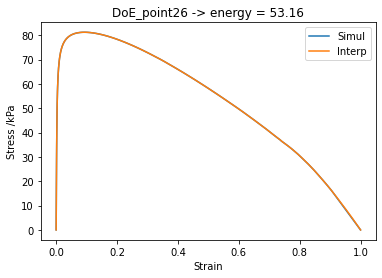

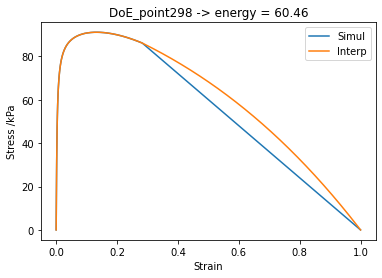

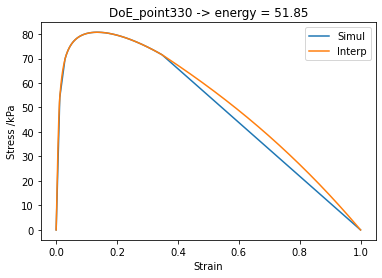

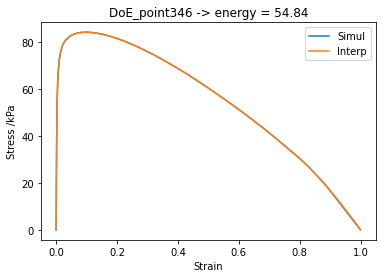

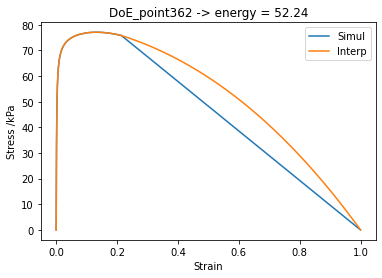

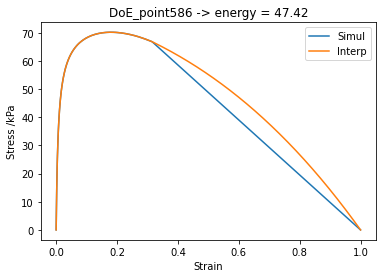

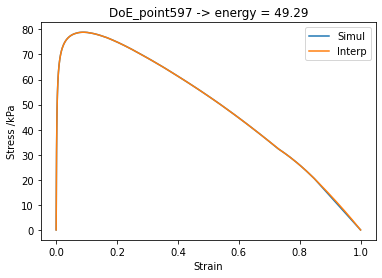

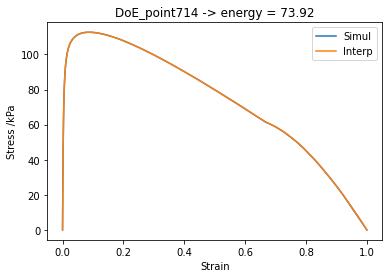

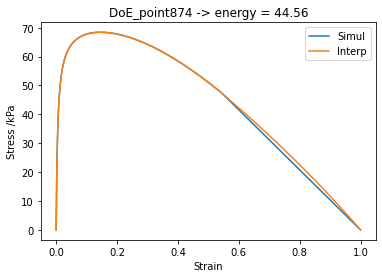

In [27]:
outliers = sorted(list(set(doe_numbers_dirty)-set(doe_numbers)))

for outlier in outliers:
    # get data
    results = get_results(data_dir, 'DoE_point{}'.format(outlier))
    coilable, sigma_crit = get_results_lin_buckle(results)
    _, (strain, stress), (energy, (xx, yy)), _ = read_and_clean_results_riks(
        results, get_energy=True)
    # plot data
    plt.figure()
    plt.plot(strain, stress, label='Simul')
    plt.xlabel('Strain')
    plt.ylabel('Stress /kPa')
    plt.plot(xx, yy, label='Interp')
    plt.title('DoE_point{} -> energy = {:.2f}'.format(outlier, energy))
    plt.legend()

Let's repeat the process, but this time  by scaling the data first (to make it Gaussian). Even though we don't have a perfect Gaussian, the output in terms of number of points to dismiss using an extreme value analisys is clear: 0.

Text(0, 0.5, 'Frequency')

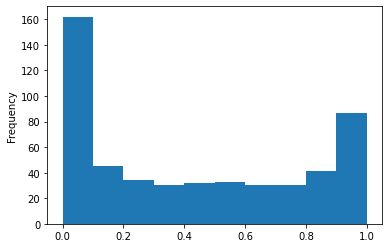

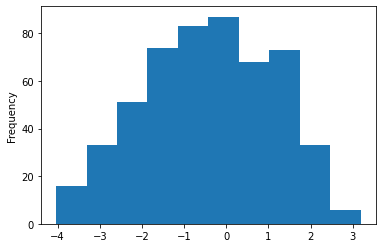

In [28]:
# from exponential to uniform
loc, scale = stats.expon.fit(y_dirty, floc=0)
lamb = 1/scale
u = 1-np.exp(-lamb*y_dirty)
fig1, ax1 = plt.subplots()
ax1.hist(u);
ax1.set_ylabel('Frequency');

# from uniform to standard normal (approximately)
z_dirty = stats.norm.ppf(u)
fig1, ax1 = plt.subplots()
ax1.hist(z_dirty)
ax1.set_ylabel('Frequency')

In [29]:
indices, n_dismissed_pts = perform_iter_outlier_cleaning(z_dirty, n_std,)

print(n_dismissed_pts)

[0]


Due the previous results, let's use all data points for further computations (neverthless, we know that other kinds of outlier detection methods could have been tried).

In [30]:
y = y_dirty
doe_numbers = doe_numbers_dirty

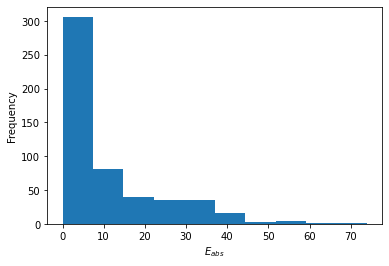

In [31]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel(var[1])
ax1.set_ylabel('Frequency');

Let's now look to the points in a 4d plot.

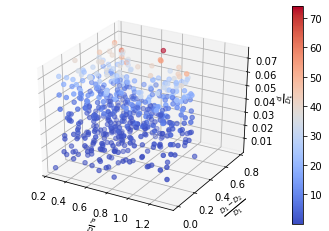

In [32]:
# access X data
X = df.iloc[doe_numbers, range(n_inputs)].values.copy()

i, j, k = 1, 2, 0
xx = X[:, i]
yy = X[:, j]
zz = X[:, k]

# 3d representation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xx, yy, zz, c=y, cmap=plt.cm.coolwarm)
ax.set_xlabel(input_vars[i][1])
ax.set_ylabel(input_vars[j][1])
ax.set_zlabel(input_vars[k][1])
clb = fig.colorbar(p)
# clb.ax.set_title(input_vars[k][1])
plt.show()

Finally, we can find in the dataset the point that corresponds to the maximum energy (and is coilable).

In [33]:
y_coil = y_coil_full[doe_numbers]
idx_coil = np.argwhere(y_coil==1).reshape(-1)
idx_max_coil = np.argmax(y[idx_coil])

doe_number_max_coil = doe_numbers[idx_coil][idx_max_coil]
df.loc[doe_number_max_coil]

ratio_d               0.0337832
ratio_pitch            0.320801
ratio_top_diameter     0.757812
coilable               coilable
sigma_crit              6.73518
energy                  3.73214
Name: 420, dtype: object

## Critical buckling load

Let's now look to the critical buckling load.


In [34]:
var = output_vars[1]

The number of outliers is **much smaller** than in the case of the energy absorbed. Note that this data is less "exponentially distributed" than the energy absorption (mean is far away from the standard deviation).

In [35]:
df[var[0]].describe()

count    949.000000
mean      18.572439
std       25.177464
min        0.000494
25%        0.558952
50%        6.203350
75%       28.341039
max      143.264914
Name: sigma_crit, dtype: float64

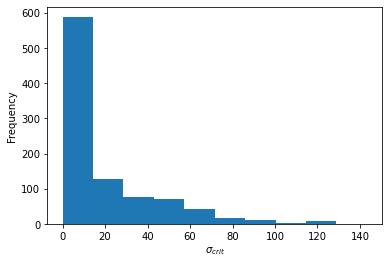

In [36]:
# missing indices
indices = pd.notnull(df.loc[:, var[0]]).values

# get y data
doe_numbers = np.arange(N)[indices]
y = df.loc[indices, var[0]].values.copy()

fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel(var[1])
ax1.set_ylabel('Frequency');

Let's now look to the points in a 4d plot.

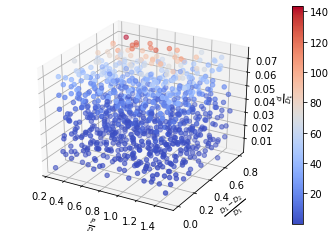

In [37]:
# access X data
X = df.iloc[indices, range(n_inputs)].values.copy()

i, j, k = 1, 2, 0
xx = X[:, i]
yy = X[:, j]
zz = X[:, k]

# 3d representation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xx, yy, zz, c=y, cmap=plt.cm.coolwarm)
ax.set_xlabel(input_vars[i][1])
ax.set_ylabel(input_vars[j][1])
ax.set_zlabel(input_vars[k][1])
clb = fig.colorbar(p)
# clb.ax.set_title(input_vars[k][1])
plt.show()

Finally, we can find in the dataset the point that corresponds to the maximum critical buckling load (and is coilable).

In [38]:
y_coil = y_coil_full[indices]
idx_coil = np.argwhere(y_coil==1).reshape(-1)
idx_max_coil = np.argmax(y[idx_coil])

doe_number_max_coil = doe_numbers[idx_coil][idx_max_coil]
df.loc[doe_number_max_coil]

ratio_d               0.0719893
ratio_pitch            0.976318
ratio_top_diameter     0.477344
coilable               coilable
sigma_crit              93.4087
energy                      NaN
Name: 981, dtype: object